# AIME Solution Pattern Analysis

Analyzes solution length patterns, truncation rates, and completion statistics across pipelines and problems.

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set global plotting style
plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,

    "axes.spines.top": False,
    "axes.spines.right": False,

    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",

    "errorbar.capsize": 3,
})

## 1. Configuration

In [15]:
# RECORDS_PATH = "../runs/aime25I_max_context_tokens_32768_max_new_tokens_sol_8192_max_new_tokens_hint_1024/records.jsonl"
RECORDS_PATH = "../runs/aime25I_max_context_tokens_32768_max_new_tokens_sol_16384_max_new_tokens_hint_1024/records.jsonl"

runs_dir = Path("../runs")
available_runs = sorted([str(p.parent.name) for p in runs_dir.glob("*/records.jsonl")])
print("Available runs:")
for i, run in enumerate(available_runs):
    run_path = runs_dir / run / "records.jsonl"
    num_lines = sum(1 for _ in open(run_path))
    print(f"  [{i}] {run} ({num_lines} records)")

Available runs:
  [0] aime25I (60 records)
  [1] aime25I_max_context_tokens_32768_max_new_tokens_sol_16384_max_new_tokens_hint_1024 (60 records)
  [2] aime25I_max_context_tokens_32768_max_new_tokens_sol_32768_max_new_tokens_hint_1024 (11 records)
  [3] aime25I_max_context_tokens_32768_max_new_tokens_sol_8192_max_new_tokens_hint_1024 (60 records)
  [4] gsmplus_200 (400 records)
  [5] gsmplus_all (1600 records)
  [6] gsmplus_gpu (15 records)
  [7] gsmplus_gpu_batch_size_4 (100 records)
  [8] gsmplus_gpu_batch_size_8 (100 records)
  [9] gsmplus_gpu_batch_size_8_max_16 (320 records)
  [10] gsmplus_gpu_batch_size_8_max_200 (4000 records)
  [11] gsmplus_test_eval (75 records)


## 2. Load and Parse Data

In [16]:
from transformers import AutoTokenizer

toks = {
    "CMU-AIRe/RLAD-Sol-Gen": AutoTokenizer.from_pretrained("CMU-AIRe/RLAD-Sol-Gen", trust_remote_code=True),
    "Qwen/Qwen3-1.7B": AutoTokenizer.from_pretrained("Qwen/Qwen3-1.7B", trust_remote_code=True),
    "Qwen/Qwen3-4B": AutoTokenizer.from_pretrained("Qwen/Qwen3-4B", trust_remote_code=True),
}


In [17]:
import json
import pandas as pd

def load_solution_stats(records_path, toks, model_id_key="solver_model_id", default_model_id=None):
    rows = []

    with open(records_path, 'r', encoding='utf-8') as f:
        for line in f:
            rec = json.loads(line)

            pipeline = rec['pipeline']
            row_idx = rec['row_idx']
            question = rec.get('question', '')[:100]
            gt = rec.get('ground_truth_answer')

            solutions = rec['solutions']
            solutions_meta = rec['solutions_meta']

            # where to get model id from:
            # 1) per-record key (common): rec[model_id_key]
            # 2) otherwise use default_model_id
            rec_model_id = rec.get(model_id_key, default_model_id)

            for abs_idx, (sol_list, meta_list) in enumerate(zip(solutions, solutions_meta)):
                for sol_idx, (sol, meta) in enumerate(zip(sol_list, meta_list)):
                    ended_eos, hit_max = meta

                    sol_len_chars = len(sol)
                    sol_len_words = len(sol.split())
                    has_boxed = r'\boxed{' in sol

                    # pick tokenizer
                    model_id = rec_model_id
                    tok = toks.get(model_id) if model_id is not None else None

                    # token length (None if we can't resolve a tokenizer)
                    len_tokens = len(tok.tokenize(sol)) if tok is not None else None

                    rows.append({
                        'pipeline': pipeline,
                        'row_idx': row_idx,
                        'question_preview': question,
                        'abs_idx': abs_idx,
                        'sol_idx': sol_idx,
                        'ended_eos': ended_eos,
                        'hit_max': hit_max,
                        'len_chars': sol_len_chars,
                        'len_words': sol_len_words,
                        'len_tokens': len_tokens,   
                        'has_boxed': has_boxed,
                        'model_id': model_id,       
                    })

    return pd.DataFrame(rows)
    
print(f"Loading from: {RECORDS_PATH}")
df = load_solution_stats(RECORDS_PATH, toks, model_id_key="solver_model_id")
print(f"\nLoaded {len(df)} solutions from {df['row_idx'].nunique()} problems")
print(f"Pipelines: {df['pipeline'].unique().tolist()}")
df.head()


Loading from: ../runs/aime25I_max_context_tokens_32768_max_new_tokens_sol_16384_max_new_tokens_hint_1024/records.jsonl

Loaded 960 solutions from 15 problems
Pipelines: ['zeroshot_solver', 'rlad_solver_no_hint', 'rlad_hint_zeroshot_solver', 'rlad_hint_rlad_solver']


,pipeline,row_idx,question_preview,abs_idx,sol_idx,ended_eos,hit_max,len_chars,len_words,len_tokens,has_boxed,model_id
0,zeroshot_solver,0,Find the sum of all integer bases $b>9$ for wh...,0,0,True,False,5647,1265,2223,True,Qwen/Qwen3-1.7B
1,zeroshot_solver,0,Find the sum of all integer bases $b>9$ for wh...,0,1,True,False,9009,1942,3591,True,Qwen/Qwen3-1.7B
2,zeroshot_solver,0,Find the sum of all integer bases $b>9$ for wh...,0,2,True,False,6067,1420,2360,True,Qwen/Qwen3-1.7B
3,zeroshot_solver,0,Find the sum of all integer bases $b>9$ for wh...,0,3,True,False,6869,1548,2589,True,Qwen/Qwen3-1.7B
4,zeroshot_solver,0,Find the sum of all integer bases $b>9$ for wh...,1,0,True,False,5138,1175,2050,True,Qwen/Qwen3-1.7B


## 3. Overall Statistics by Pipeline


SOLUTION STATISTICS BY PIPELINE
                           total_solutions  ended_eos_count  hit_max_count  \
pipeline                                                                     
rlad_hint_rlad_solver                  240              160             80   
rlad_hint_zeroshot_solver              240              180             60   
rlad_solver_no_hint                    240              126            114   
zeroshot_solver                        240              135            105   

                           has_boxed_count  mean_len_chars  median_len_chars  \
pipeline                                                                       
rlad_hint_rlad_solver                  176         34857.0           40294.0   
rlad_hint_zeroshot_solver              186         30937.0           34847.0   
rlad_solver_no_hint                    140         38128.0           43108.0   
zeroshot_solver                        139         35310.0           39504.0   

                 

/tmp/ipykernel_14387/675495311.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')


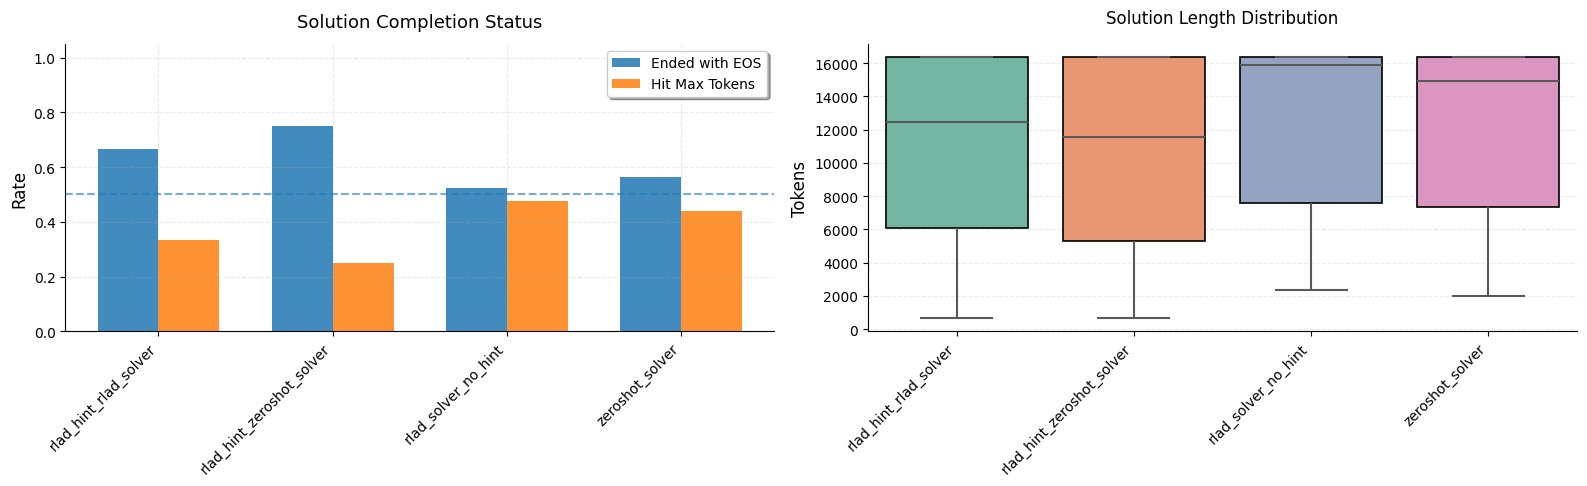

In [18]:
pipeline_stats = df.groupby('pipeline').agg(
    total_solutions=('pipeline', 'size'),
    ended_eos_count=('ended_eos', 'sum'),
    hit_max_count=('hit_max', 'sum'),
    has_boxed_count=('has_boxed', 'sum'),
    mean_len_chars=('len_chars', 'mean'),
    median_len_chars=('len_chars', 'median'),
    mean_len_words=('len_tokens', 'mean'),
).round(0)

pipeline_stats['eos_rate'] = (pipeline_stats['ended_eos_count'] / pipeline_stats['total_solutions']).round(3)
pipeline_stats['hit_max_rate'] = (pipeline_stats['hit_max_count'] / pipeline_stats['total_solutions']).round(3)
pipeline_stats['has_boxed_rate'] = (pipeline_stats['has_boxed_count'] / pipeline_stats['total_solutions']).round(3)

print("\n" + "="*80)
print("SOLUTION STATISTICS BY PIPELINE")
print("="*80)
print(pipeline_stats)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

pipelines = pipeline_stats.index
x = np.arange(len(pipelines))

width = 0.35
bars1 = axes[0].bar(x - width/2, pipeline_stats['eos_rate'], width, label='Ended with EOS', 
                    linewidth=0.8, alpha=0.85)
bars2 = axes[0].bar(x + width/2, pipeline_stats['hit_max_rate'], width, label='Hit Max Tokens', 
                     linewidth=0.8, alpha=0.85)
axes[0].set_ylabel('Rate')
axes[0].set_title('Solution Completion Status', pad=12)
axes[0].set_xticks(x)
axes[0].set_xticklabels(pipelines, rotation=45, ha='right', fontsize=10)
axes[0].legend(frameon=True, fancybox=True, shadow=True)
axes[0].set_ylim(0, 1.05)
axes[0].axhline(0.5, linestyle='--', alpha=0.6, linewidth=1.5)

order = pipeline_stats.index.tolist() 

pal = dict(zip(order, sns.color_palette("Set2", n_colors=len(order))))

bp2 = sns.boxplot(
    data=df, x='pipeline', y='len_tokens',
    order=order,
    hue='pipeline',          
    palette=pal,
    dodge=False,             
    ax=axes[1],
    linewidth=1.5,
    fliersize=3
)


axes[1].set_ylabel('Tokens', fontsize=12)
axes[1].set_xlabel('')
axes[1].set_title('Solution Length Distribution', fontsize=12, pad=15)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

# keep your edge styling
for patch in bp2.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1.2)

plt.tight_layout()
# save the figure in pdf
plt.savefig("../figures/solution_pattern_analysis_aimeI_16k.pdf", bbox_inches='tight', dpi=300)
plt.show()

## 4. Solution Length Distribution by Pipeline

/tmp/ipykernel_14387/257885151.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp1 = sns.boxplot(data=df, x='pipeline', y='len_chars', ax=axes[0],
/tmp/ipykernel_14387/257885151.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_14387/257885151.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp2 = sns.boxplot(data=df, x='pipeline', y='len_words', ax=axes[1],
/tmp/ipykernel_14387/257885151.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].

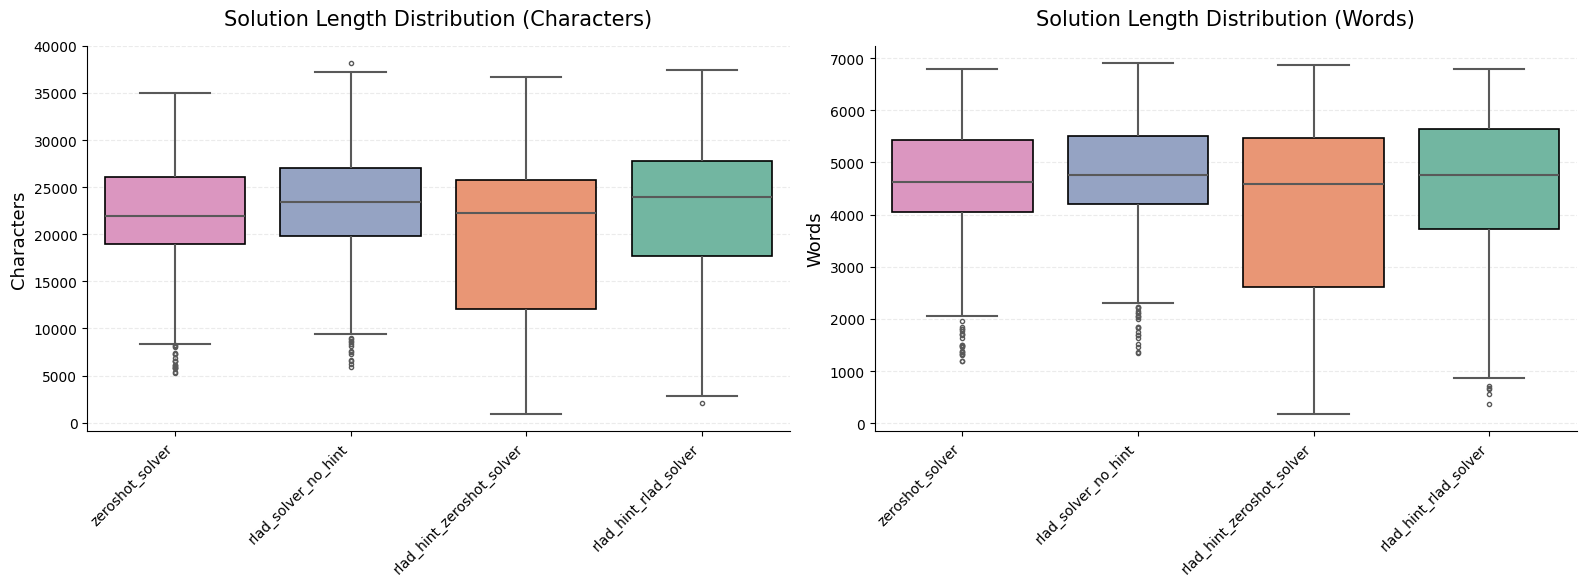


Length Statistics:
                           count     mean     std     min      25%      50%  \
pipeline                                                                      
rlad_hint_rlad_solver      240.0  22237.0  8467.0  2121.0  17740.0  23992.0   
rlad_hint_zeroshot_solver  240.0  19802.0  9434.0   939.0  12080.0  22266.0   
rlad_solver_no_hint        240.0  23049.0  7304.0  5954.0  19798.0  23458.0   
zeroshot_solver            240.0  21830.0  7425.0  5287.0  18997.0  21946.0   

                               75%      max  
pipeline                                     
rlad_hint_rlad_solver      27814.0  37432.0  
rlad_hint_zeroshot_solver  25723.0  36733.0  
rlad_solver_no_hint        26995.0  38147.0  
zeroshot_solver            26132.0  34956.0  


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

bp1 = sns.boxplot(data=df, x='pipeline', y='len_chars', ax=axes[0], 
                   palette=pal, linewidth=1.5, fliersize=3)
axes[0].set_ylabel('Characters', fontsize=13)
axes[0].set_xlabel('')
axes[0].set_title('Solution Length Distribution (Characters)', fontsize=15, pad=15)
axes[0].tick_params(axis='x', rotation=45, labelsize=10)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
for patch in bp1.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1.2)

bp2 = sns.boxplot(data=df, x='pipeline', y='len_words', ax=axes[1], 
                   palette=pal, linewidth=1.5, fliersize=3)
axes[1].set_ylabel('Words', fontsize=13)
axes[1].set_xlabel('')
axes[1].set_title('Solution Length Distribution (Words)', fontsize=15, pad=15)
axes[1].tick_params(axis='x', rotation=45, labelsize=10)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
for patch in bp2.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1.2)

plt.tight_layout()
plt.show()

print("\nLength Statistics:")
print(df.groupby('pipeline')['len_chars'].describe().round(0))

## 5. Truncation Analysis: Completed vs. Truncated Solutions

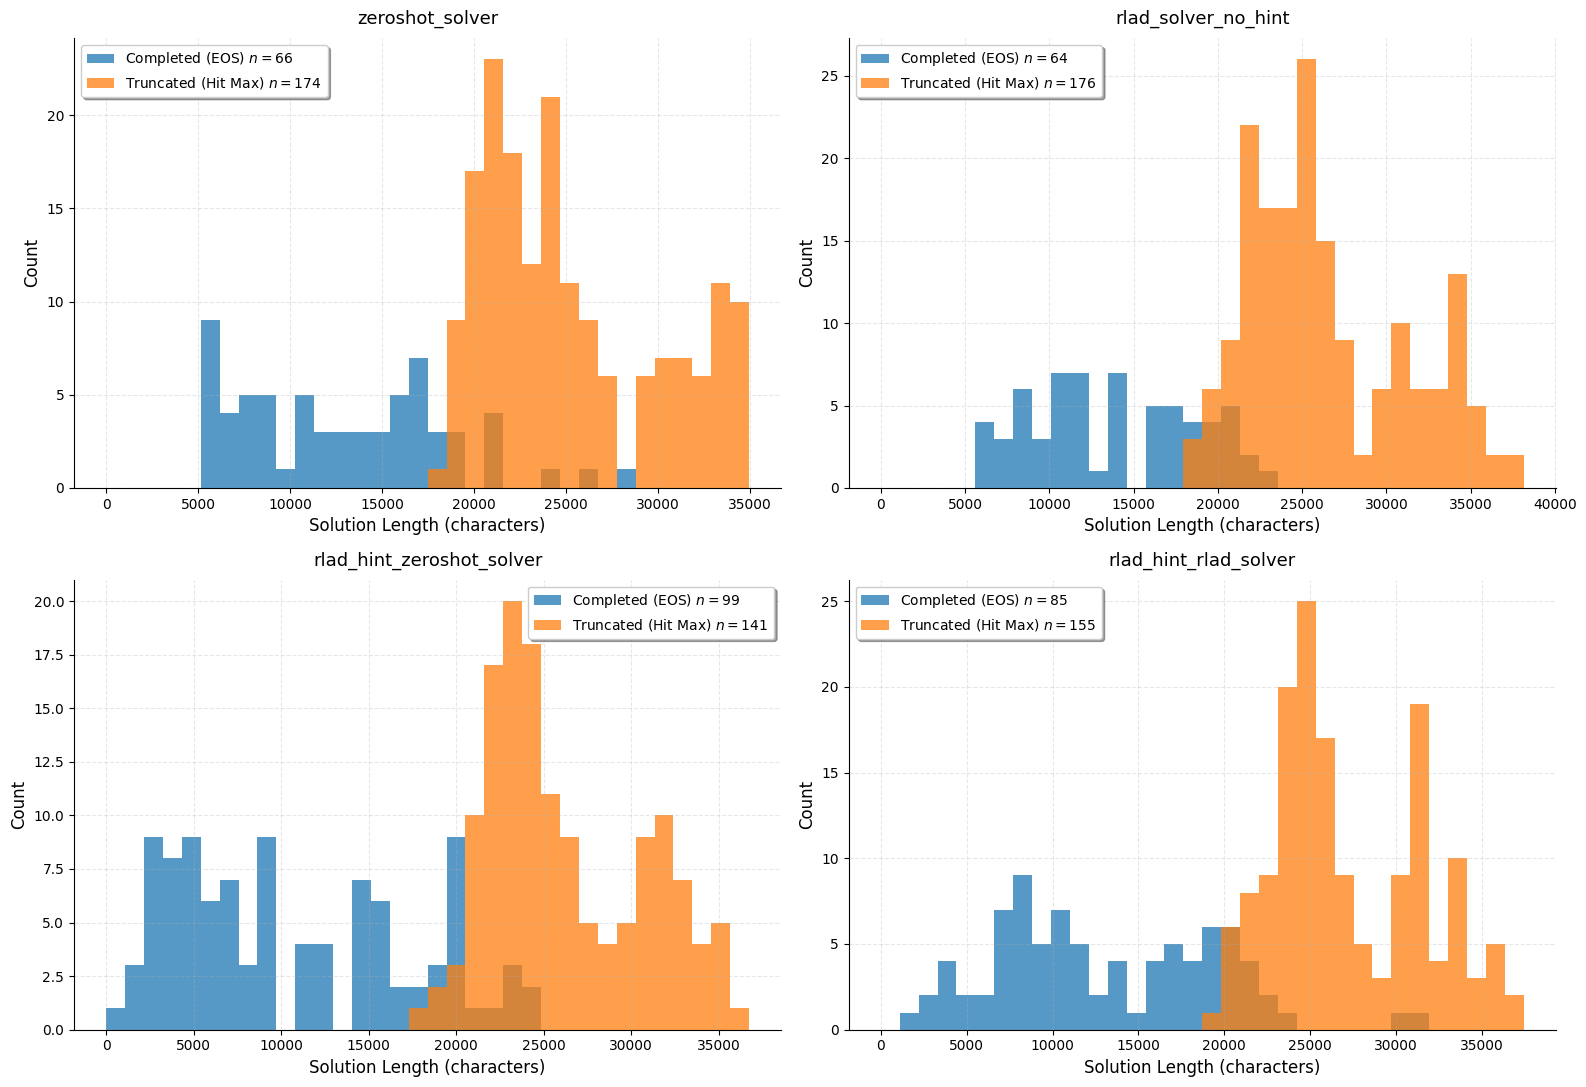


Length Comparison: Completed vs Truncated

zeroshot_solver:
  Completed avg: 12939 chars
  Truncated avg: 25202 chars
  Difference: +12263 chars (94.8% longer)

rlad_solver_no_hint:
  Completed avg: 13831 chars
  Truncated avg: 26401 chars
  Difference: +12570 chars (90.9% longer)

rlad_hint_zeroshot_solver:
  Completed avg: 10654 chars
  Truncated avg: 26225 chars
  Difference: +15571 chars (146.2% longer)

rlad_hint_rlad_solver:
  Completed avg: 13184 chars
  Truncated avg: 27202 chars
  Difference: +14019 chars (106.3% longer)


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 11))

for idx, pipeline in enumerate(df['pipeline'].unique()):
    ax = axes[idx // 2, idx % 2]
    
    df_pipe = df[df['pipeline'] == pipeline]
    completed = df_pipe[df_pipe['ended_eos']]['len_chars']
    truncated = df_pipe[df_pipe['hit_max']]['len_chars']
    
    bins = np.linspace(0, df_pipe['len_chars'].max(), 35)
    ax.hist(completed, bins=bins, alpha=0.75, label=f'Completed (EOS) $n={len(completed)}$', 
         linewidth=0.8)
    ax.hist(truncated, bins=bins, alpha=0.75, label=f'Truncated (Hit Max) $n={len(truncated)}$', 
            linewidth=0.8)
    
    ax.set_xlabel('Solution Length (characters)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'{pipeline}', fontsize=13, pad=10)
    ax.legend(frameon=True, fancybox=True, shadow=True, fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\nLength Comparison: Completed vs Truncated")
for pipeline in df['pipeline'].unique():
    df_pipe = df[df['pipeline'] == pipeline]
    completed_mean = df_pipe[df_pipe['ended_eos']]['len_chars'].mean()
    truncated_mean = df_pipe[df_pipe['hit_max']]['len_chars'].mean()
    print(f"\n{pipeline}:")
    print(f"  Completed avg: {completed_mean:.0f} chars")
    print(f"  Truncated avg: {truncated_mean:.0f} chars")
    print(f"  Difference: +{truncated_mean - completed_mean:.0f} chars ({(truncated_mean/completed_mean - 1)*100:.1f}% longer)")

## 6. Per-Problem Analysis: Which Problems Cause Truncation?


TOP 10 PROBLEMS WITH HIGHEST TRUNCATION RATE
 row_idx                                                                                     question_preview  hit_max_rate  mean_len_chars
       8 The parabola with equation $y=x^{2}-4$ is rotated $60^{\circ}$ counterclockwise around the origin. T      0.984375    23321.796875
      11 The set of points in 3-dimensional coordinate space that lie in the plane $x+y+z=75$ whose coordinat      0.968750    25230.187500
      13 Let $ABCDE$ be a convex pentagon with $AB=14, BC=7, CD=24, DE=13, EA=26,$ and $\angle B=\angle E=60^      0.953125    26512.625000
       1 On $\triangle ABC$ points $A,D,E$, and $B$ lie that order on side $\overline{AB}$ with $AD=4, DE=16$      0.906250    22070.875000
       9 The 27 cells of a $3\times9$ grid are filled in using the numbers 1 through 9 so that each row conta      0.906250    28188.046875
      14 Let $N$ denote the number of ordered triples of positive integers $(a,b,c)$ such that $a,b,c\leq3^6$     

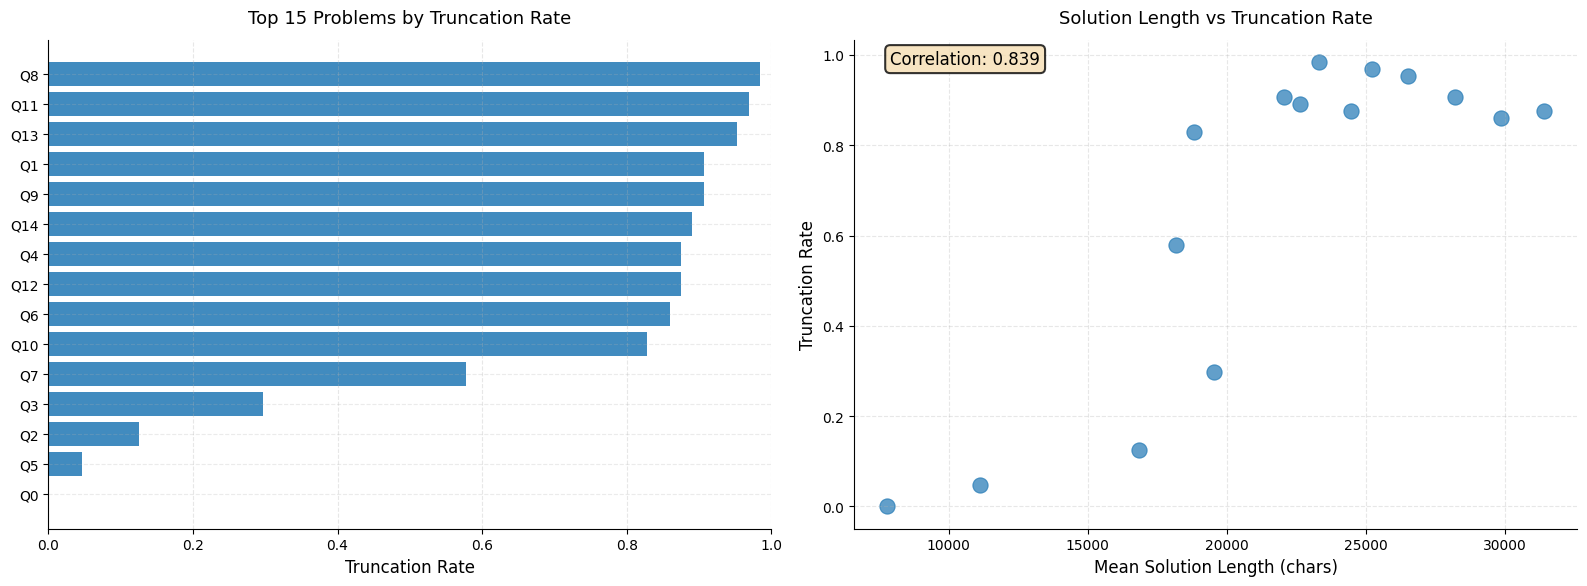

In [9]:
problem_stats = df.groupby(['row_idx', 'question_preview']).agg(
    total_solutions=('row_idx', 'size'),
    hit_max_count=('hit_max', 'sum'),
    mean_len_chars=('len_chars', 'mean'),
    max_len_chars=('len_chars', 'max'),
).reset_index()

problem_stats['hit_max_rate'] = (problem_stats['hit_max_count'] / problem_stats['total_solutions'])
problem_stats = problem_stats.sort_values('hit_max_rate', ascending=False)

print("\n" + "="*80)
print("TOP 10 PROBLEMS WITH HIGHEST TRUNCATION RATE")
print("="*80)
print(problem_stats[['row_idx', 'question_preview', 'hit_max_rate', 'mean_len_chars']].head(10).to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top_n = 15
top_problems = problem_stats.head(top_n)
bars = axes[0].barh(range(len(top_problems)), top_problems['hit_max_rate'], 
                     linewidth=0.8, alpha=0.85)
axes[0].set_yticks(range(len(top_problems)))
axes[0].set_yticklabels([f"Q{r}" for r in top_problems['row_idx']], fontsize=10)
axes[0].set_xlabel('Truncation Rate',  fontsize=12)
axes[0].set_title(f'Top {top_n} Problems by Truncation Rate',  fontsize=13, pad=12)
axes[0].invert_yaxis()
axes[0].set_xlim(0, 1)
axes[0].grid(True, alpha=0.3, linestyle='--', axis='x')

scatter = axes[1].scatter(problem_stats['mean_len_chars'], problem_stats['hit_max_rate'], 
                          alpha=0.7, s=120, linewidth=0.8)
axes[1].set_xlabel('Mean Solution Length (chars)', fontsize=12)
axes[1].set_ylabel('Truncation Rate', fontsize=12)
axes[1].set_title('Solution Length vs Truncation Rate',  fontsize=13, pad=12)
axes[1].grid(True, alpha=0.3, linestyle='--')

corr = problem_stats[['mean_len_chars', 'hit_max_rate']].corr().iloc[0, 1]
axes[1].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
             transform=axes[1].transAxes, fontsize=12,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, linewidth=1.5))

plt.tight_layout()
plt.show()

## 7. Boxed Answer Analysis: Do Truncated Solutions Have Answers?


BOXED ANSWER RATE: COMPLETED VS TRUNCATED
                    pipeline  completed_boxed_rate  truncated_boxed_rate  \
0            zeroshot_solver                   1.0                 0.040   
1        rlad_solver_no_hint                   1.0                 0.062   
2  rlad_hint_zeroshot_solver                   1.0                 0.014   
3      rlad_hint_rlad_solver                   1.0                 0.032   

   difference  
0      -0.960  
1      -0.938  
2      -0.986  
3      -0.968  


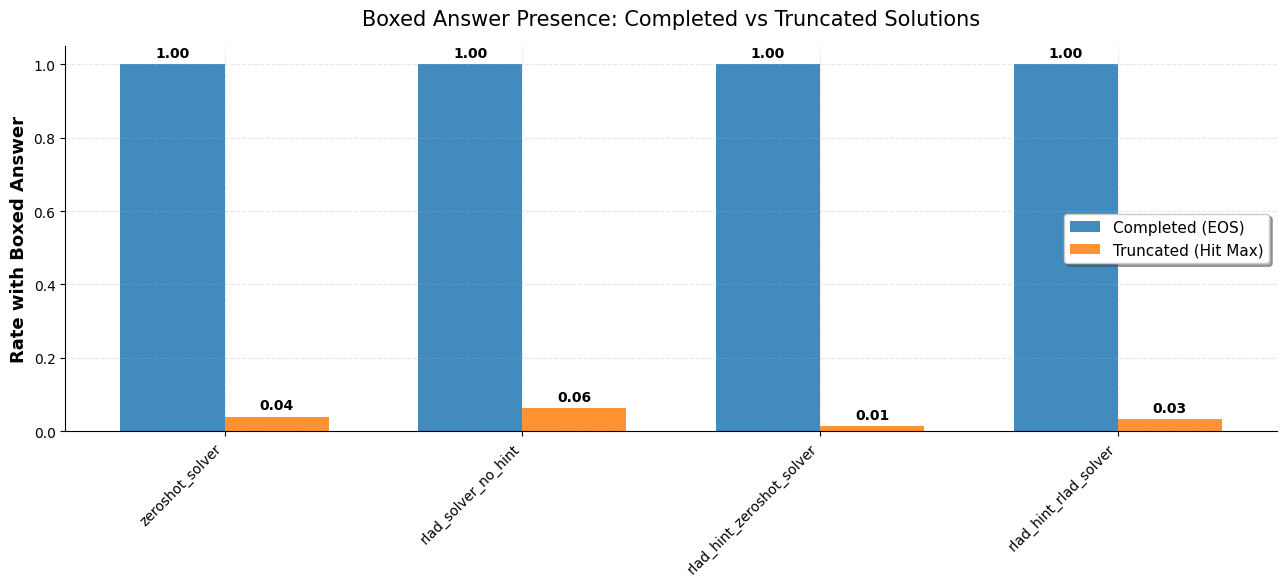

In [10]:
comparison_data = []

for pipeline in df['pipeline'].unique():
    df_pipe = df[df['pipeline'] == pipeline]
    completed = df_pipe[df_pipe['ended_eos']]
    completed_boxed_rate = completed['has_boxed'].mean()
    truncated = df_pipe[df_pipe['hit_max']]
    truncated_boxed_rate = truncated['has_boxed'].mean()
    
    comparison_data.append({
        'pipeline': pipeline,
        'completed_boxed_rate': completed_boxed_rate,
        'truncated_boxed_rate': truncated_boxed_rate,
        'difference': truncated_boxed_rate - completed_boxed_rate,
    })

comp_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("BOXED ANSWER RATE: COMPLETED VS TRUNCATED")
print("="*80)
print(comp_df.round(3))

fig, ax = plt.subplots(figsize=(13, 6))

x = np.arange(len(comp_df))
width = 0.35

bars1 = ax.bar(x - width/2, comp_df['completed_boxed_rate'], width, 
               label='Completed (EOS)', alpha=0.85, linewidth=0.8)
bars2 = ax.bar(x + width/2, comp_df['truncated_boxed_rate'], width,
               label='Truncated (Hit Max)', alpha=0.85, linewidth=0.8)

ax.set_ylabel('Rate with Boxed Answer', fontsize=13, fontweight='bold')
ax.set_title('Boxed Answer Presence: Completed vs Truncated Solutions', fontsize=15,  pad=15)
ax.set_xticks(x)
ax.set_xticklabels(comp_df['pipeline'], rotation=45, ha='right', fontsize=10)
ax.legend(frameon=True, fancybox=True, shadow=True, fontsize=11)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3, axis='y', linestyle='--')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


## 8. Pattern Analysis Summary Table

In [11]:
summary_rows = []

for pipeline in df['pipeline'].unique():
    df_pipe = df[df['pipeline'] == pipeline]
    completed = df_pipe[df_pipe['ended_eos']]
    truncated = df_pipe[df_pipe['hit_max']]
    
    summary_rows.append({
        'Pipeline': pipeline,
        'Total Solutions': len(df_pipe),
        'EOS Rate': f"{completed['ended_eos'].count() / len(df_pipe):.1%}",
        'Hit Max Rate': f"{truncated['hit_max'].count() / len(df_pipe):.1%}",
        'Avg Len (Completed)': f"{completed['len_chars'].mean():.0f}",
        'Avg Len (Truncated)': f"{truncated['len_chars'].mean():.0f}",
        'Boxed Rate (Completed)': f"{completed['has_boxed'].mean():.1%}",
        'Boxed Rate (Truncated)': f"{truncated['has_boxed'].mean():.1%}",
    })

summary_df = pd.DataFrame(summary_rows)

print("\n" + "="*100)
print("COMPREHENSIVE PATTERN ANALYSIS SUMMARY")
print("="*100)
print(summary_df.to_string(index=False))


COMPREHENSIVE PATTERN ANALYSIS SUMMARY
                 Pipeline  Total Solutions EOS Rate Hit Max Rate Avg Len (Completed) Avg Len (Truncated) Boxed Rate (Completed) Boxed Rate (Truncated)
          zeroshot_solver              240    27.5%        72.5%               12939               25202                 100.0%                   4.0%
      rlad_solver_no_hint              240    26.7%        73.3%               13831               26401                 100.0%                   6.2%
rlad_hint_zeroshot_solver              240    41.2%        58.8%               10654               26225                 100.0%                   1.4%
    rlad_hint_rlad_solver              240    35.4%        64.6%               13184               27202                 100.0%                   3.2%
